<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model.

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

we extract the data required for our analysis using pandas datareader.

In [3]:
import yfinance as yf
import pandas_datareader.data as web
import datetime

# Define your tickers
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

# Define the time period for data (optional, you can adjust the dates)
start_date = "2019-09-04"
end_date = "2024-09-01"

# Fetch stock data using yfinance
stk_data = yf.download(stk_tickers, start=start_date, end=end_date)

# Fetch currency and index data using pandas_datareader
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

# Display the fetched data
print("Stock Data:\n", stk_data.head())
print("\nCurrency Data:\n", ccy_data.head())
print("\nIndex Data:\n", idx_data.head())


[*********************100%***********************]  3 of 3 completed


Stock Data:
 Price                      Adj Close                              Close  \
Ticker                         GOOGL         IBM        MSFT      GOOGL   
Date                                                                      
2019-09-04 00:00:00+00:00  59.045731  102.878571  131.457275  59.113499   
2019-09-05 00:00:00+00:00  60.540020  106.387863  133.768753  60.609501   
2019-09-06 00:00:00+00:00  60.246857  106.085976  132.861374  60.316002   
2019-09-09 00:00:00+00:00  60.194416  107.618019  131.352234  60.263500   
2019-09-10 00:00:00+00:00  60.215889  109.466949  129.976837  60.285000   

Price                                                   High              \
Ticker                            IBM        MSFT      GOOGL         IBM   
Date                                                                       
2019-09-04 00:00:00+00:00  130.325043  137.630005  59.243999  130.430206   
2019-09-05 00:00:00+00:00  134.770554  140.050003  60.700001  135.468445   
2019-0

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [4]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [5]:
stk_data.index = stk_data.index.tz_localize(None)
ccy_data.index = ccy_data.index.tz_localize(None)
idx_data.index = idx_data.index.tz_localize(None)

In [6]:
# Define Y (MSFT Future Returns)
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

# Define X
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

# Combine Y and X into the final dataset
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [8]:
pd.set_option('display.precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,226.000,226.000,226.000,2.260e+02,2.260e+02,226.000,226.000,226.000,226.000,226.000,226.000,226.000
mean,0.005,0.004,0.002,9.838e-04,8.430e-06,0.002,0.001,0.001,0.004,0.013,0.027,0.059
std,0.033,0.041,0.036,1.267e-02,1.299e-02,0.025,0.025,0.141,0.035,0.060,0.079,0.103
min,-0.120,-0.144,-0.157,-4.592e-02,-7.346e-02,-0.131,-0.164,-0.447,-0.120,-0.153,-0.238,-0.247
25%,-0.014,-0.022,-0.018,-4.872e-03,-6.921e-03,-0.007,-0.011,-0.081,-0.017,-0.022,-0.023,-0.013
50%,0.009,0.008,0.004,1.193e-03,1.594e-04,0.003,0.003,-0.013,0.009,0.019,0.037,0.065
75%,0.028,0.029,0.023,8.713e-03,8.248e-03,0.016,0.014,0.076,0.027,0.050,0.086,0.134
max,0.089,0.136,0.132,3.683e-02,5.530e-02,0.062,0.079,0.630,0.089,0.147,0.244,0.306


In [9]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2019-11-27,-1.581e-02,0.008,0.004,0.007,-0.003,1.443e-02,0.012,-0.084,0.018,0.059,0.085,0.105
2019-12-06,1.815e-02,0.027,-0.009,-0.007,0.014,1.568e-03,-0.001,0.076,0.002,0.028,0.084,0.102
2019-12-13,1.847e-02,0.006,0.007,0.006,0.017,7.250e-03,0.004,-0.075,0.018,0.033,0.078,0.095
2019-12-20,1.143e-03,0.003,0.010,0.002,-0.024,1.641e-02,0.011,-0.010,0.018,0.039,0.091,0.124
2019-12-30,-6.365e-05,-0.009,-0.021,-0.005,0.017,-8.440e-04,-0.003,0.161,0.001,0.038,0.066,0.149


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

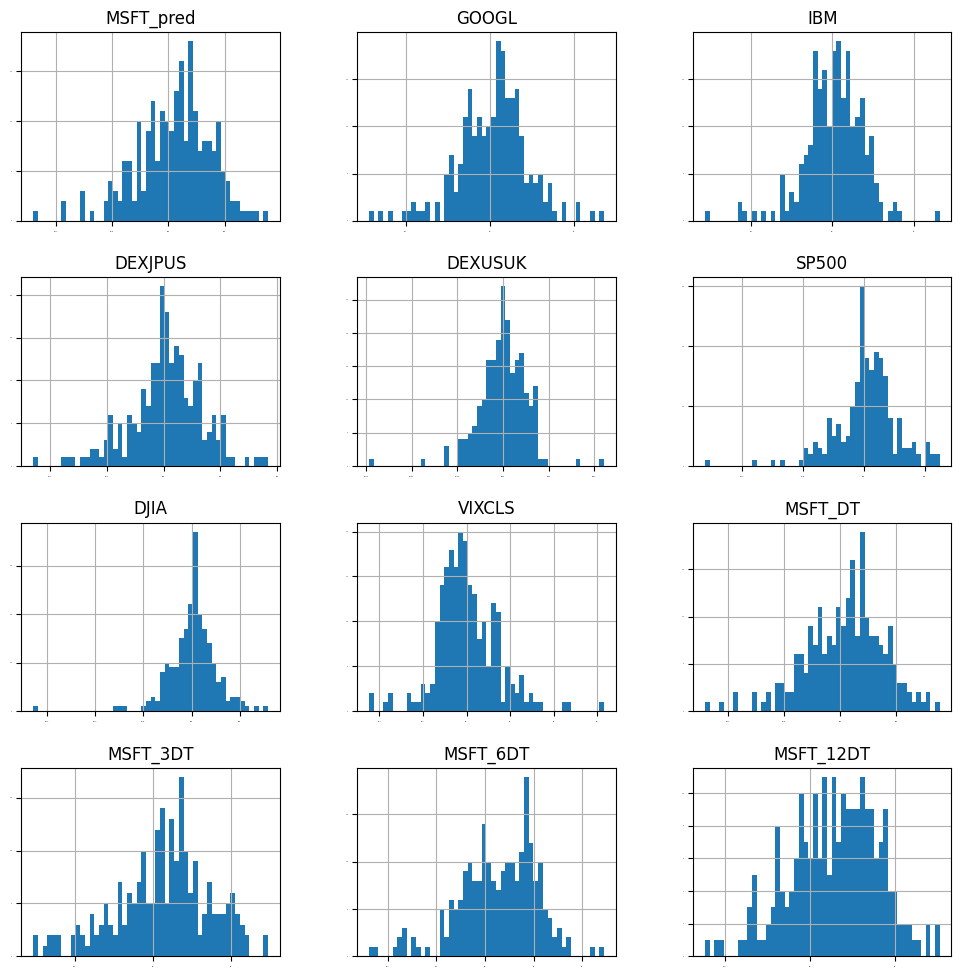

In [10]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

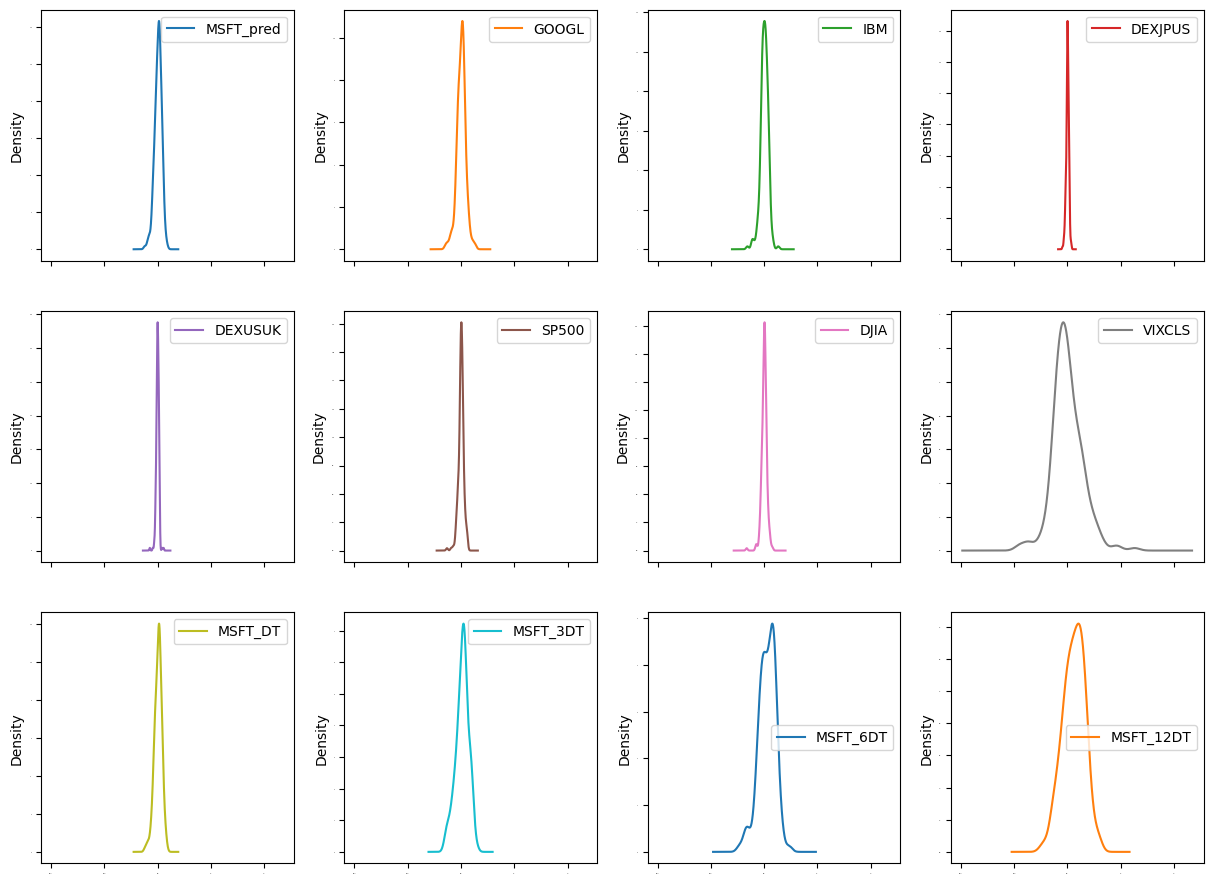

In [11]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<Axes: title={'center': 'Correlation Matrix'}>

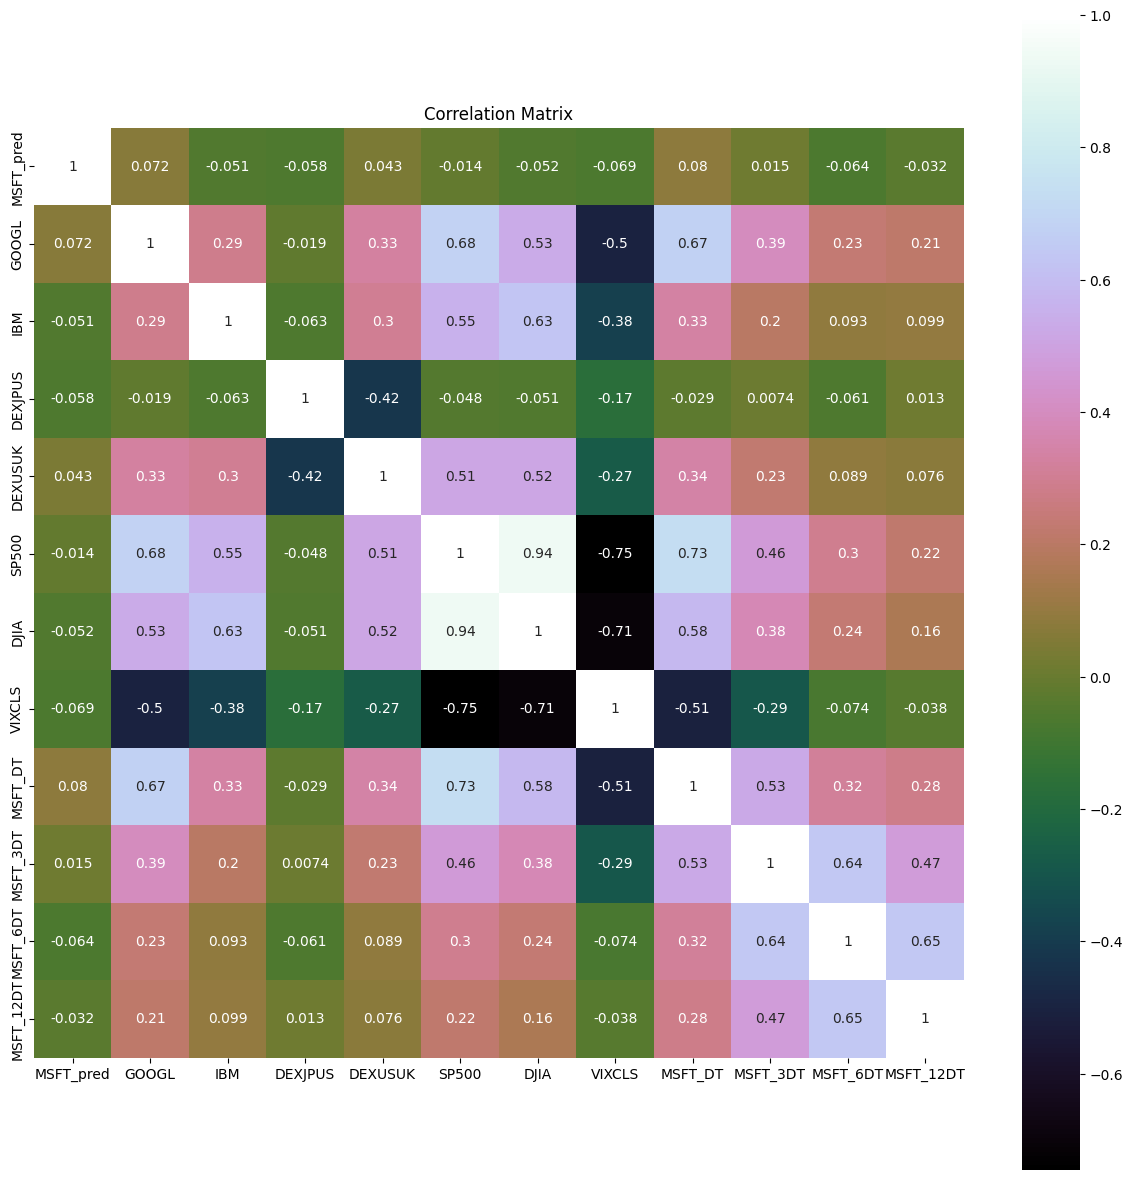

In [12]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted vari‐
able with the lagged 5 days, 15days, 30 days and 60 days return of MSFT.

<Figure size 1500x1500 with 0 Axes>

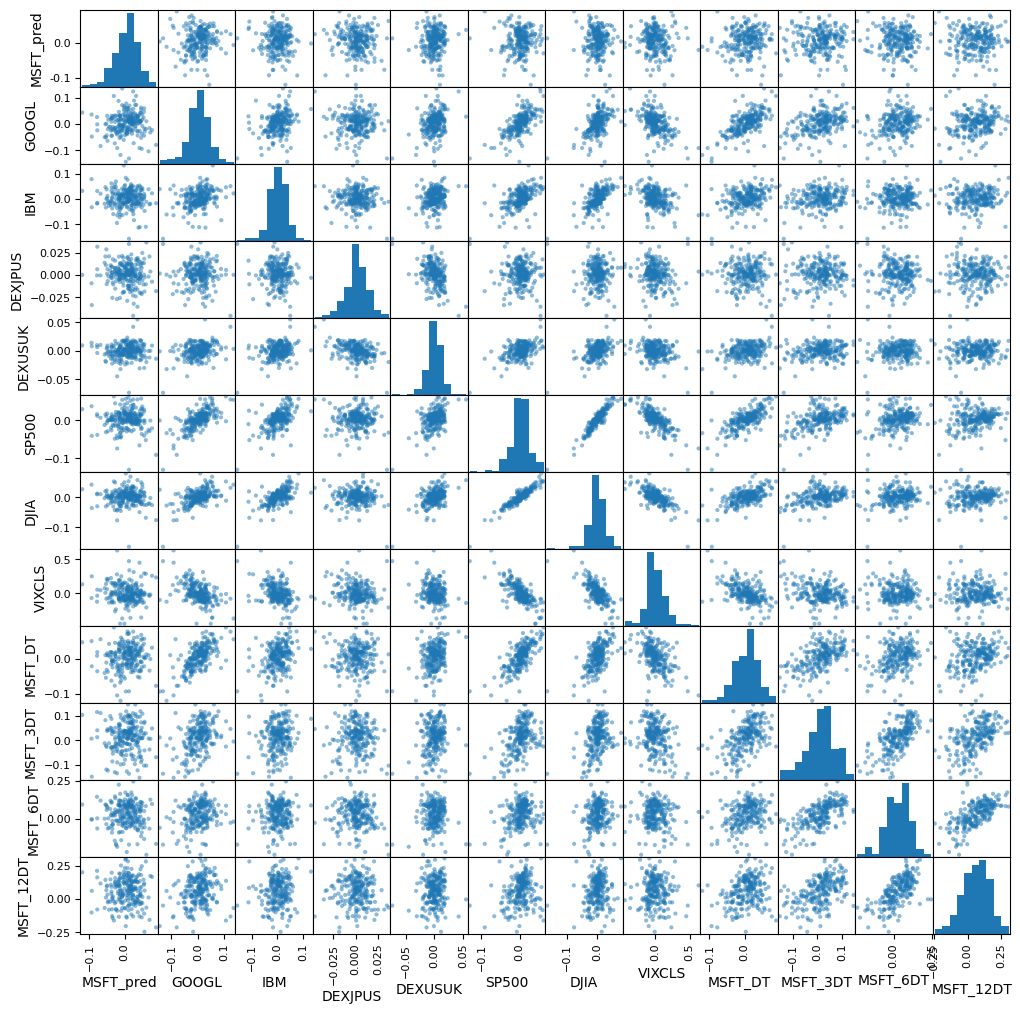

In [13]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis

Next, we look at the seasonal decomposition of our time series

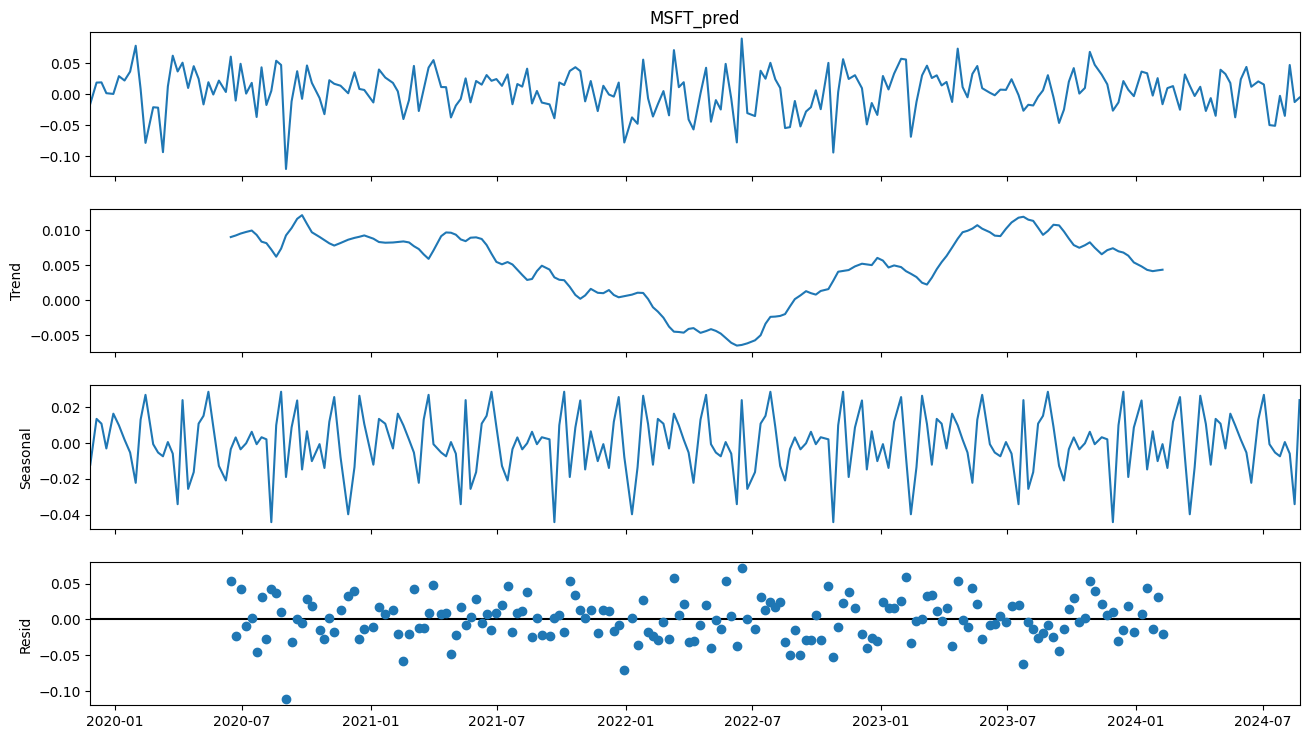

In [16]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance.

In [17]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,1.444
GOOGL,1.161
VIXCLS,1.062
MSFT_6DT,0.928
DEXJPUS,0.753
DJIA,0.597
IBM,0.594
DEXUSUK,0.410
MSFT_12DT,0.232


<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

In [18]:
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:]
Y_train, Y_test = Y[0:train_size], Y[train_size:]

In [19]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

In [20]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [21]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [23]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)

    # K-Fold analysis
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

    # Convert mean squared error to positive. The lower, the better.
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(Y_train, res.predict(X_train))
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(Y_test, res.predict(X_test))
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001335 (0.000640) 0.001104 0.000812
LASSO: 0.001196 (0.000441) 0.001183 0.000795
EN: 0.001196 (0.000441) 0.001183 0.000795
KNN: 0.001267 (0.000532) 0.000808 0.000978
CART: 0.002379 (0.000755) 0.000000 0.002231
SVR: 0.001667 (0.000508) 0.001658 0.001292
ABR: 0.001274 (0.000482) 0.000586 0.000801
GBR: 0.001493 (0.000520) 0.000094 0.001015
RFR: 0.001279 (0.000498) 0.000186 0.000939
ETR: 0.001320 (0.000596) 0.000000 0.000963


#### K Fold results

We being by looking at the K Fold results

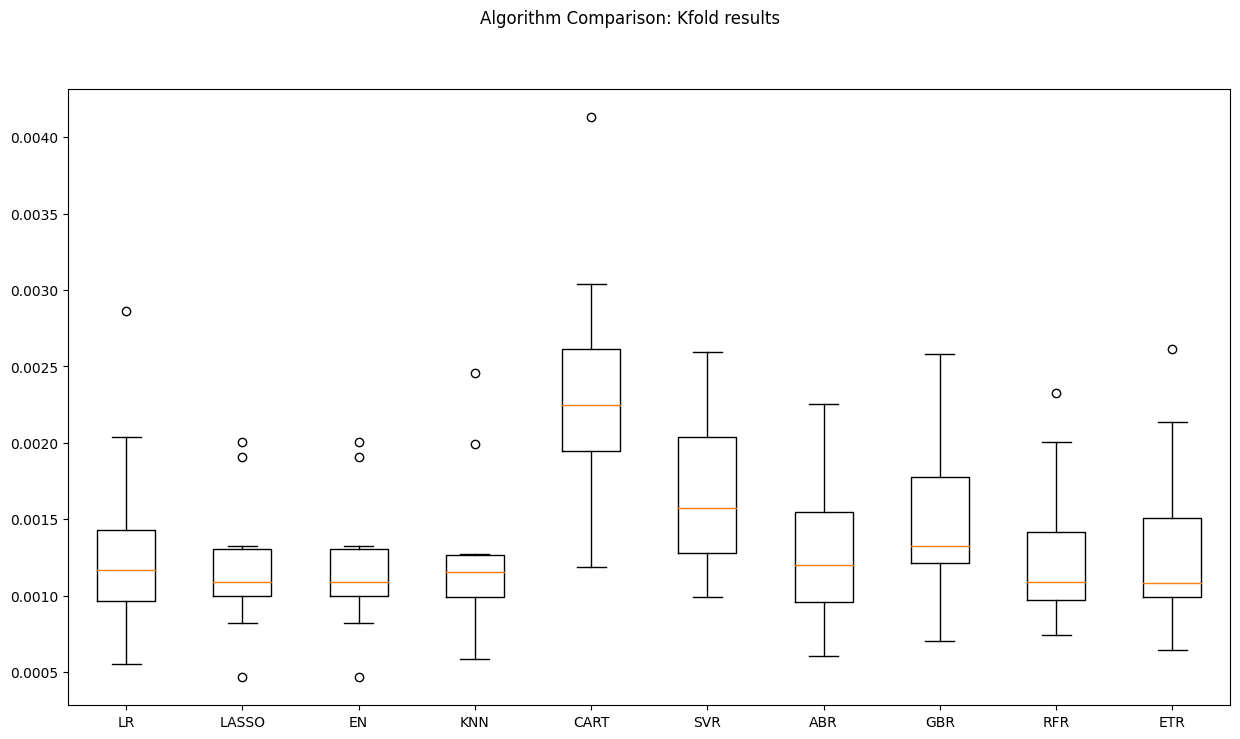

In [24]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

#### Training and Test error

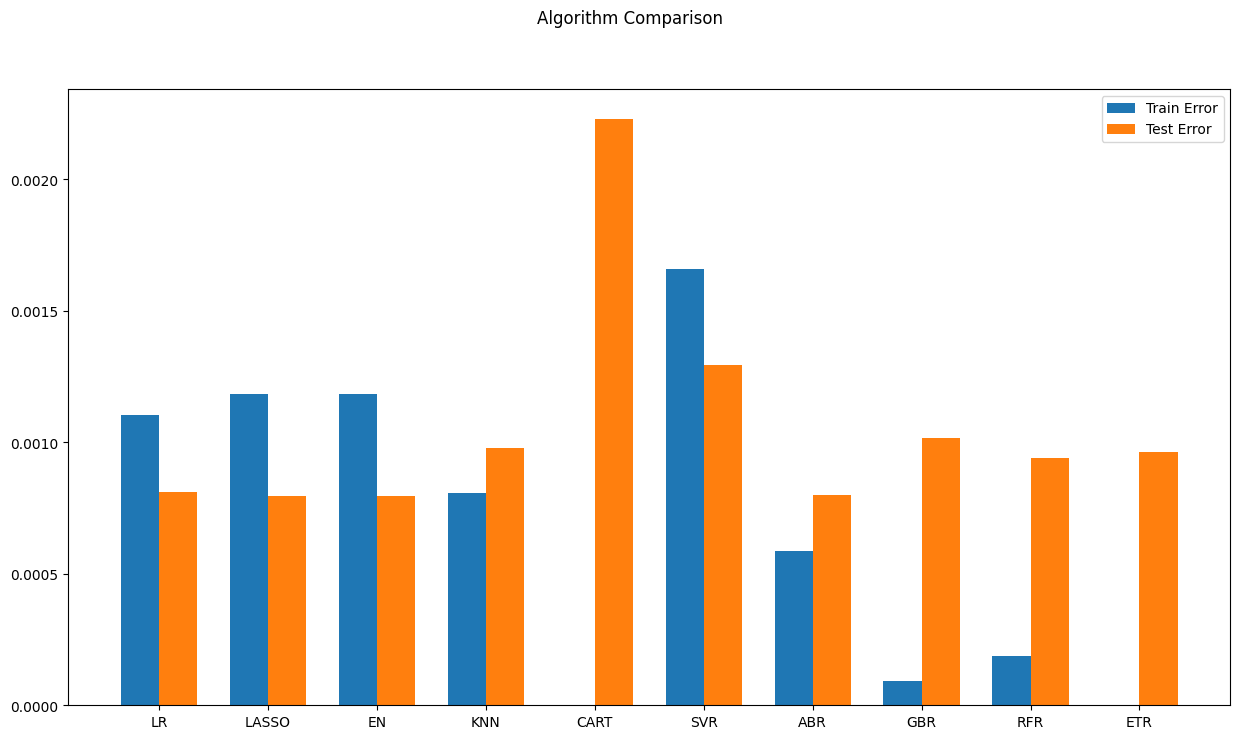

In [25]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

In [27]:
def evaluate_knn_model(params):
    n_neighbors, weights, metric = params
    modelKNN = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    modelKNN.fit(X_train, Y_train)
    Y_pred = modelKNN.predict(X_train)
    error = mean_squared_error(Y_train, Y_pred)
    return error

# Evaluate combinations of n_neighbors, weights, and metric for the KNN Regressor model
def evaluate_models(n_neighbors_values, weights_values, metric_values):
    best_score, best_params = float("inf"), None
    for n_neighbors in n_neighbors_values:
        for weights in weights_values:
            for metric in metric_values:
                params = (n_neighbors, weights, metric)
                try:
                    mse = evaluate_knn_model(params)
                    if mse < best_score:
                        best_score, best_params = mse, params
                    print('KNN%s MSE=%.7f' % (params, mse))
                except Exception as e:
                    print(f"Error with params {params}: {e}")
                    continue
    print('Best KNN%s MSE=%.7f' % (best_params, best_score))
    return best_params, best_score  # Make sure to return the best parameters and score

# Example parameters to evaluate
n_neighbors_values = range(1, 26)  # K values from 1 to 25
weights_values = ['uniform', 'distance']
metric_values = ['euclidean', 'manhattan']

# Evaluate the models
warnings.filterwarnings("ignore")
best_params, best_score = evaluate_models(n_neighbors_values, weights_values, metric_values)


KNN(1, 'uniform', 'euclidean') MSE=0.0000000
KNN(1, 'uniform', 'manhattan') MSE=0.0000000
KNN(1, 'distance', 'euclidean') MSE=0.0000000
KNN(1, 'distance', 'manhattan') MSE=0.0000000
KNN(2, 'uniform', 'euclidean') MSE=0.0005005
KNN(2, 'uniform', 'manhattan') MSE=0.0005233
KNN(2, 'distance', 'euclidean') MSE=0.0000000
KNN(2, 'distance', 'manhattan') MSE=0.0000000
KNN(3, 'uniform', 'euclidean') MSE=0.0006262
KNN(3, 'uniform', 'manhattan') MSE=0.0007236
KNN(3, 'distance', 'euclidean') MSE=0.0000000
KNN(3, 'distance', 'manhattan') MSE=0.0000000
KNN(4, 'uniform', 'euclidean') MSE=0.0007507
KNN(4, 'uniform', 'manhattan') MSE=0.0008190
KNN(4, 'distance', 'euclidean') MSE=0.0000000
KNN(4, 'distance', 'manhattan') MSE=0.0000000
KNN(5, 'uniform', 'euclidean') MSE=0.0008083
KNN(5, 'uniform', 'manhattan') MSE=0.0008459
KNN(5, 'distance', 'euclidean') MSE=0.0000000
KNN(5, 'distance', 'manhattan') MSE=0.0000000
KNN(6, 'uniform', 'euclidean') MSE=0.0008808
KNN(6, 'uniform', 'manhattan') MSE=0.0008998


In [28]:
n_neighbors, weights, metric = best_params
modelKNN_tuned = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
modelKNN_tuned.fit(X_train, Y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=1)

In [29]:
Y_pred_tuned = modelKNN_tuned.predict(X_test)

In [30]:
mse_tuned = mean_squared_error(Y_test, Y_pred_tuned)
print(f"Mean Squared Error (MSE) with fine-tuned KNN model: {mse_tuned}")

Mean Squared Error (MSE) with fine-tuned KNN model: 0.0016483552634928773


In [31]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(modelKNN_tuned, open(filename, 'wb'))

We can conclude that K-Nearest Neighbors (KNN) is a viable approach for asset price prediction, particularly when the relationship between variables is complex and non-linear. KNN offers a flexible, non-parametric method that can capture patterns in data without making strong assumptions about the underlying distribution. This makes it a useful tool in financial modeling, where data relationships can be intricate and vary over time.

However, while KNN is powerful, it also requires careful selection of parameters such as the number of neighbors and the distance metric. These choices can significantly impact the model's performance, and cross-validation is crucial to avoid overfitting. Additionally, the performance of KNN can be enhanced by incorporating a richer set of features, such as technical indicators, trading volumes, or sentiment analysis from news data, which can lead to more accurate predictions.

Overall, we have integrated KNN into a supervised learning framework that complements other models, such as linear regression and ARIMA, enabling a comprehensive approach to asset price prediction. This framework helps in analyzing potential risks and profitability, providing financial practitioners with valuable insights before making investment decisions.